In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
import glob 
import matplotlib.image as img
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
import numpy as np
import math
import csv
from PIL import Image
import time
import sklearn.metrics
import random
import onnx
import onnxruntime
import onnxscript

In [2]:
# set device 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("device type:", device)
print("current device:", torch.cuda.get_device_name(torch.cuda.current_device()))

# dtype = torch.float

device type: cuda
current device: NVIDIA GeForce GTX 1060 6GB


In [3]:
# map labels to ids (alphabetically)

classIdByLabel = {}
classNames : list = sorted(os.listdir(os.path.join("..", "dane", "test")))
i = 0
for className in classNames:
    classIdByLabel[className] = i
    i += 1

# print("classIdByLabel:\n" + "\n".join([(str(classIdByLabel[c]) + "\t" + c) for c in classIdByLabel]))

# save ids and labels to file
# file = open("../dane/id_label.txt", "w")
# for label in classNames:
#     file.write(str(classIdByLabel[label]) + ";" + label +"\n")

In [4]:
# create a dataset class

class BirdDataset(Dataset):
    def __init__(self, dataset_type: str, classNames, transform=None):
        self.transform = transform
        self.image_paths = [path for sublist in [glob.glob(os.path.join("..", "dane", dataset_type, label, "*.jpg"), recursive=False) for label in classNames] for path in sublist] 
        self.labels = torch.tensor([classIdByLabel[path.split("/")[3]] for path in self.image_paths])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, i):

        image = Image.open(self.image_paths[i])

        if self.transform:
            image = self.transform(image)
        
        return image, self.labels[i]


In [5]:
# create an early stopper

class EarlyStopper:
    def __init__(self, patience=1, min_change=0, mode='min'):
        self.patience = patience
        self.min_change = min_change
        self.mode = mode
        self.counter = 0
        self.min_variable = float('inf')
        self.max_variable = float('-inf')

    def stop_early(self, variable):
        if self.mode == 'min':
            if variable < self.min_variable:
                self.min_variable = variable
                self.counter = 0
            elif (variable - self.min_variable) > self.min_change:
                self.counter += 1
                if self.counter > self.patience:
                    return True
                
        elif self.mode == 'max':
            if variable > self.max_variable:
                self.max_variable = variable
                self.counter = 0
            elif (self.max_variable - variable) > self.min_change:
                self.counter += 1
                if self.counter > self.patience:
                    return True
                
        return False

dataset size: 7490


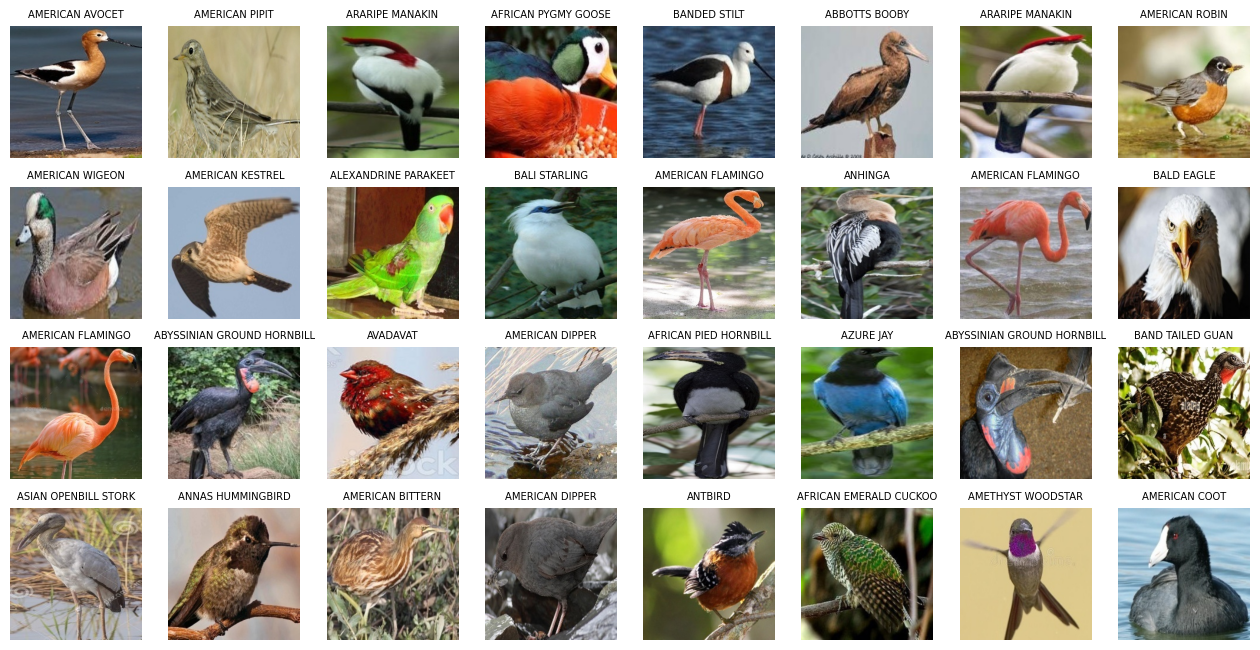

In [6]:
# show single batch of example data

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
    ])
example_batch_size = 32
example_number_of_classes = 63
exampleTrainDataset = BirdDataset("train", classNames[:example_number_of_classes], transform)

print("dataset size:", len(exampleTrainDataset))
# checkClasses = set([path.split("/")[3] for path in exampleTrainDataset.image_paths])
# print("all labels:", checkClasses)
# print("all image paths:\n", "\n".join(exampleTrainDataset.image_paths))

exampleTrainLoader = DataLoader(exampleTrainDataset, batch_size=example_batch_size, shuffle=True, num_workers=4, drop_last=True)

for i_batch, sample_batch in enumerate(exampleTrainLoader):
    images_batch, labels_batch = sample_batch
    # print(i_batch, images_batch[0].size(), len(labels_batch))

    # observe 4th batch and stop.
    if i_batch == 4:
        plt.figure(figsize=(16,8))
        plt.rc('font', size=6)

        for index in range(example_batch_size):
            plt.subplot(4,8,index+1)
            plt.imshow(images_batch[index].squeeze().permute(1,2,0))
            plt.title(list(classIdByLabel.keys())[list(classIdByLabel.values()).index(labels_batch[index])])
            plt.axis('off')

        
        plt.ioff()
        plt.show()
        break

In [7]:
# tune a pretrained model

number_of_classes = 525

weights = torchvision.models.EfficientNet_B0_Weights.IMAGENET1K_V1
model = torchvision.models.efficientnet_b0(weights=weights)
preprocess = weights.transforms()
in_features = model.classifier[1].in_features
# print("in_features:", in_features)

dropout = 0.2
model.classifier = nn.Sequential(
    # nn.Dropout(dropout),
    nn.Linear(in_features, 900),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(900, 650),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(650, number_of_classes)
)

for name, param in model.named_parameters():
    if name.split(".")[0] == "classifier":
        param.requires_grad = True
    else: 
        param.requires_grad = False

# print(model)

In [8]:
# create datasets 

batch_size = 32

trainDataset = BirdDataset("train", classNames[:number_of_classes], preprocess)
trainLoader = DataLoader(trainDataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=False)

validDataset = BirdDataset("valid", classNames[:number_of_classes], preprocess)
validLoader = DataLoader(validDataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=False)

testDataset = BirdDataset("test", classNames[:number_of_classes], preprocess)
testLoader = DataLoader(testDataset, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=False)

In [9]:
# calculate class weights

classWeights = [0 for _ in range(525)]

# total = len(trainDataset.image_paths)

for className in classNames[:number_of_classes]:
    classWeights[classIdByLabel[className]] = 100.0 /len(os.listdir(os.path.join("..", "dane", "train", className)))
    # print(classWeights[classIdByLabel[className]], className)
print("min:", min(classWeights[:number_of_classes]), "max:", max(classWeights[:number_of_classes]))


min: 0.5208333333333334 max: 1.0204081632653061


In [10]:
# train
trainModel = False

criterion = nn.CrossEntropyLoss(weight = torch.tensor(classWeights[:number_of_classes]).to(device))
optimizer = torch.optim.SGD(model.parameters(), lr=3e-3, momentum=0.9) # , weight_decay=1e-5
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1, threshold_mode='abs', verbose=True) 
early_stopper = EarlyStopper(patience=2, min_change=0,  mode='max')
batch_print_step = 500
epochs = 50
best_val_loss = float('inf')

# if torch.cuda.device_count() > 1:
#     model = nn.DataParallel(model) # saving not supported
model.to(device)

if trainModel:
    for epoch in range(epochs):

        correct = 0
        running_loss = 0.0
        valid_running_loss = 0.0
        all_input_labels = []
        all_predicted_labels = []
        timestart = time.time()
        epochtime = time.time()

        # train
        model.train()
        for i, data in enumerate(trainLoader, 0):        
            # get the inputs
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(images)
            

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item() * images.size(0)
            
            if i % batch_print_step == batch_print_step-1:
                print("\r", f'[epoch: {epoch + 1}, {100*batch_size*(i + 1)/len(trainDataset):.3f}%, {math.floor(time.time() - timestart):3d}s] loss: {running_loss / len(trainDataset):.3f}', end="")
                timestart = time.time()

        # validate 
        model.eval()
        for i, data in enumerate(validLoader, 0):
            # get the inputs
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            loss = criterion(outputs, labels)

            # print statistics
            valid_running_loss += loss.item() * images.size(0)
            correct += torch.sum(predicted == labels.data)
            all_predicted_labels.append(predicted.cpu())
            all_input_labels.append(labels.cpu())
        
        epoch_loss = valid_running_loss / len(validDataset)
        accuracy = correct.double() / len(validDataset)
        all_input_labels = np.concatenate(all_input_labels)
        all_predicted_labels = np.concatenate(all_predicted_labels)
        f1_score = sklearn.metrics.f1_score(all_input_labels, all_predicted_labels, average='weighted', sample_weight=[classWeights[label_id] for label_id in all_input_labels])

        print("\r" + f'[epoch: {epoch + 1:2d}/{epochs}, time: {math.floor(time.time() - epochtime)}s] loss: {epoch_loss:.3f}, f1 score: {f1_score:.3f}, accuracy: {accuracy:.3f}')
            
        if early_stopper.stop_early(f1_score):
            print("stopping early")
            break

        scheduler.step(epoch_loss)

    print('done')

else:
    print("trainModel set to false")

trainModel set to false


In [11]:
# save/load the model

version = 1
savepath = os.path.join("..", "saved_models", "model_" + str(number_of_classes) + "_ver" + str(version) + ".pt")
if trainModel:
    torch.save(model.state_dict(), savepath)
    print("saved model_" + str(number_of_classes) + "_ver" + str(version) + ".pt")
else:
    model.load_state_dict(torch.load(savepath))
    model.eval()
    print("loaded model_" + str(number_of_classes) + "_ver" + str(version) + ".pt")

loaded model_525_ver1.pt


In [12]:
# test the model

testModel = False

if testModel:
    model.eval()

    test_running_loss = 0
    correct = 0
    all_predicted_labels = []
    all_input_labels = []

    for i, data in enumerate(testLoader, 0):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        test_running_loss += loss.item() * images.size(0)
        correct += torch.sum(predicted == labels.data)
        all_predicted_labels.append(predicted.cpu())
        all_input_labels.append(labels.cpu())

    final_loss = valid_running_loss / len(testDataset)
    accuracy = correct.double() / len(testDataset)
    all_input_labels = np.concatenate(all_input_labels)
    all_predicted_labels = np.concatenate(all_predicted_labels)
    f1_score = sklearn.metrics.f1_score(all_input_labels, all_predicted_labels, average='weighted', sample_weight=[classWeights[label_id] for label_id in all_input_labels])

    print("Test: ")
    print(f'loss: {final_loss:.3f}, f1 score: {f1_score:.3f}, accuracy: {accuracy:.3f}')


In [13]:
# export model to onnx

# test single input
randomDatapoint = testDataset[random.randint(0, len(testDataset)-1)]
image, labelId = randomDatapoint
model_input = image.to(device).unsqueeze(0)
print("single random input:", classNames[labelId])

model_output = model(model_input)
_, predicted = torch.max(model_output, 1)
print("pytorch output:", classNames[predicted])


# export model to onnx
onnx_savepath = os.path.join("..", "saved_models", "model_" + str(number_of_classes) + "_ver" + str(version) + ".onnx")

torch.onnx.export(model, model_input, onnx_savepath)

# perform a check
onnx_model = onnx.load(onnx_savepath)
onnx.checker.check_model(onnx_model)

# allows to use the same dataLoader with onnx
def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# test onnx model
onnxTestLoader = DataLoader(testDataset, batch_size=1, shuffle=False, num_workers=4, drop_last=False)

ort_provider = ['CUDAExecutionProvider'] if (torch.cuda.is_available()) else ['CPUExecutionProvider']
ort_sess = onnxruntime.InferenceSession(onnx_savepath, providers=ort_provider)

correct = 0
all_predicted_labels = []
all_input_labels = []

for i, data in enumerate(onnxTestLoader, 0):
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)

    inputs = {ort_sess.get_inputs()[0].name: to_numpy(images)}
    outputs = ort_sess.run(None, inputs)[0]
    predicted = np.argmax(outputs, axis=1)
    correct += np.sum(np.equal(predicted, to_numpy(labels)))

    all_predicted_labels.append(predicted.cpu())
    all_input_labels.append(labels.cpu())


single random input: NOISY FRIARBIRD
pytorch output: NOISY FRIARBIRD


In [15]:
accuracy = float(correct.item()) / len(testDataset)
print(accuracy)
all_input_labels = np.concatenate(all_input_labels)
all_predicted_labels = np.concatenate(all_predicted_labels)
f1_score = sklearn.metrics.f1_score(all_input_labels, all_predicted_labels, average='weighted', sample_weight=[classWeights[label_id] for label_id in all_input_labels])

print("Test: ")
print(f'f1 score: {f1_score:.3f}, accuracy: {accuracy:.3f}')

0.8127102803738318


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.